In [65]:
import pandas as pd
import numpy as np
from bs4 import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,6)
plt.rcParams["patch.force_edgecolor"] = True
sns.set()

In [5]:
filename = 'sample_data.txt'
data = open(filename,'r')
soup = BeautifulSoup(data,'lxml')

In [6]:
#Capture all field names
obj = soup.objectdata
features = {n.name:[] for n in obj}
#Grab field information for each field
for obj in soup.find_all('objectdata'):
    for feature in features.keys():
        features[feature].append(obj.find(feature))
df = pd.DataFrame(features)
df.head(2)

,barcode,condition,deviceid,devicename,general,hostmessage,incr,ocsdata,scaledata,seqnb,sorterstate,sortstate,timestamp,tokenid,volumetric
0,"<barcode cc=""1"" vcc=""1""><codevalid id=""r""><st>...","<condition>NoRead,ValidDim,NotLFT</condition>",<deviceid>32</deviceid>,<devicename>0089PS06CT1</devicename>,"<general errornb=""0"" ie=""15589"" iostate=""8800""...",<hostmessage>PDF</hostmessage>,<incr>21126</incr>,<ocsdata><rxstring>07/07/2017;23:56:44;0111.6;...,"<scaledata ows=""19""><owe unit=""LB""><value>111....",<seqnb>5864</seqnb>,"<sorterstate state=""started""><speed unit=""ft/m...","<sortstate session=""SOS"" sortname=""2017-07-07 ...",<timestamp>2017-07-07T23:00:05.633</timestamp>,<tokenid>0089PS06CT12017-07-07T23:00:03417</to...,"<volumetric oms1=""0000"" oms2=""00000000"" oms3=""..."
1,"<barcode cc=""1"" vcc=""1""><codevalid id=""j""><st>...","<condition>ValidDim,ValidWeight,ValidRead,PDFN...",<deviceid>32</deviceid>,<devicename>0089PS06CT1</devicename>,"<general errornb=""0"" ie=""16743"" iostate=""8800""...",<hostmessage>]C0037962200190000357853670078708...,<incr>22266</incr>,<ocsdata><rxstring>07/07/2017;23:56:45;0007.2;...,"<scaledata ows=""0""><owe unit=""LB""><value>7.20<...",<seqnb>5865</seqnb>,"<sorterstate state=""started""><speed unit=""ft/m...","<sortstate session=""SOS"" sortname=""2017-07-07 ...",<timestamp>2017-07-07T23:00:06.061</timestamp>,<tokenid>0089PS06CT12017-07-07T23:00:04418</to...,"<volumetric oms1=""0000"" oms2=""00000000"" oms3=""..."


In [7]:
"""Pre-process label for each example"""
#Create dictionary to assign encoded integer to each class.
classes = ['LFT','TooBig','NoRead','ValidDim','MultiRead','Irreg','TooSmall','Gap']
class_dict = {classes[i]:i for i in range(len(classes))}

#Extract and encode contents of condition field only for conditions listed in the `classes` list
conditions = [[class_dict[c] for c in obj.condition.contents[0].split(',') if c in classes]\
              for obj in soup.find_all('objectdata')]
##Perform one-hot-encoding
#Initialize matrix
conditions_encoded = np.zeros([len(conditions),len(classes)])
#Encode position in matrix for place of class
for c in range(len(conditions)):
    conditions_encoded[c,conditions[c]] = 1
#Store in dataframe
label_df = pd.DataFrame(conditions_encoded,columns=classes).astype(int)

In [34]:
"""Extract relevant information from each field for all objects"""
cols = ['date','time','height','width','length','volume','weight','angle','gap','velocity','velocity_units','belt_velocity',\
        'belt_velocity_units']
#Initialize dictionary for storing extracted data
data = {}
for obj in soup.find_all('objectdata'):
    #Time stamp
    [date,time] = obj.timestamp.contents[0].split('T')
    #Gap information
    gap = float(obj.oga.value.contents[0])
    #Item volume
    vol_keys = ['ohe','owi','ole']
    [height,width,length] = [float(obj.volumetric.size.attrs[key]) for key in vol_keys]
    vol = height*width*length
    vol_units = obj.volumetric.size.attrs['unit']
    #Item angle
    angle = int(obj.volumetric.oa.value.contents[0])
    #Item Velocity
    vel = int(obj.volumetric.otve.value.contents[0])
    vel_units = obj.volumetric.otve.attrs['unit']
    #Item weight
    weight = float(obj.scaledata.value.contents[0]) #In lbs
    #Conveyor belt velocity
    belt_vel = float(obj.sorterstate.speed.value.contents[0])
    belt_vel_units = obj.sorterstate.speed.attrs['unit']
    
    #Add data to dictionary
    d = [date,time,height,width,length,vol,weight,angle,gap,vel,vel_units,belt_vel,belt_vel_units]
    for k,v in zip(cols,d):
        #Initialize each entry with an empty list and then append new value
        data[k] = data.get(k,[])+[v]
#Construct dataframe
df = pd.DataFrame(data,columns=cols)
#Add labels
df = df.join(label_df)
#Save as csv
df.to_csv('sampledata.csv',index=False)

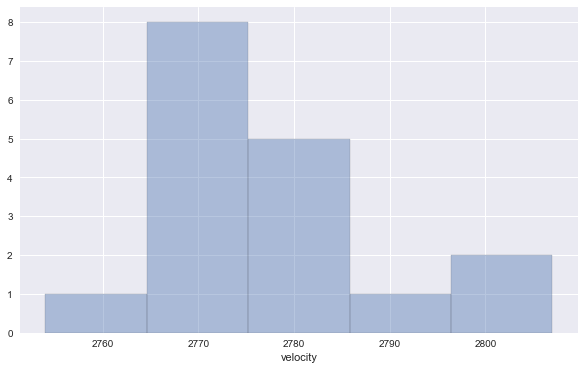

In [66]:
sns.distplot(df.velocity,kde=False)
plt.show()

In [32]:
for n in soup.heartbeatdata:
    print(n)
    print()

<devicename>0089PS06CT1</devicename>

<deviceid>32</deviceid>

<timestamp>2017-07-07T23:00:13.295</timestamp>

<incr>41571</incr>

<general errornb="0" iostate="8800"></general>

<sorterstate state="started"><speed unit="ft/min"><value>540.55</value></speed></sorterstate>

<sortstate session="SOS" sortname="2017-07-07 21:20:34"></sortstate>

<systemstate><warning dn="32" errorid="03000400" extinfo="CAN1: Dev. 1" numberoccurance="69"><firsttimeoccur>2017-05-30T10:06:22</firsttimeoccur><lasttimeoccur>2017-07-07T19:58:39</lasttimeoccur></warning><warning dn="32" errorid="03000400" extinfo="CAN1: Dev. 4" numberoccurance="71"><firsttimeoccur>2017-05-30T10:06:25</firsttimeoccur><lasttimeoccur>2017-07-07T20:19:49</lasttimeoccur></warning><warning dn="32" errorid="03000400" extinfo="CAN1: Dev. 3" numberoccurance="71"><firsttimeoccur>2017-05-30T10:06:29</firsttimeoccur><lasttimeoccur>2017-07-07T19:05:16</lasttimeoccur></warning><warning dn="32" errorid="03000400" extinfo="CAN1: Dev. 2" numberoc